In [1]:
import sys

sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv
from torch_geometric.transforms import ToUndirected

In [13]:
from src.utils import set_random_seed

set_random_seed(0)


def load_german_data():
    df = pd.read_csv("../data/german/german.csv")
    columns = list(df.columns)

    sens_attr = "Gender"
    predict_attr = "GoodCustomer"

    columns.remove(sens_attr)
    columns.remove(predict_attr)
    columns.remove("OtherLoansAtStore")
    columns.remove("PurposeOfLoan")

    features = df[columns].values

    # Normalize features to have mean 0 and std 1
    # TODO: very slight data leakage here, but it's not a big deal
    features = (features - features.mean(axis=0)) / features.std(axis=0)

    # -1, 0 --> 0, 1
    labels = df[predict_attr].values
    labels[labels == -1] = 0

    sens_attrs = df[sens_attr].values.reshape(-1, 1)
    sens_attrs[sens_attrs == "Female"] = 1
    sens_attrs[sens_attrs == "Male"] = 0
    sens_attrs = sens_attrs.astype(int)

    idx = np.arange(features.shape[0], dtype=int)
    idx_map = {j: i for i, j in enumerate(idx)}
    edge_unordered = np.genfromtxt("../data/german/german_edges.txt", dtype=float).astype(int)
    edges = np.array(
        list(map(idx_map.get, edge_unordered.flatten())), dtype=int
    ).reshape(edge_unordered.shape)

    # Among the labeled nodes, randomly select 100 validation, 100 test, rest training
    labels_idx = np.arange(labels.shape[0], dtype=int)
    val_test_idx = np.random.choice(labels_idx, size=200, replace=False)
    val_idx = np.random.choice(val_test_idx, size=100, replace=False)
    test_idx = np.setdiff1d(val_test_idx, val_idx)
    train_idx = np.setdiff1d(labels_idx, val_test_idx)

    train_mask = np.zeros(labels.shape, dtype=bool)
    train_mask[train_idx] = True

    val_mask = np.zeros(labels.shape, dtype=bool)
    val_mask[val_idx] = True

    test_mask = np.zeros(labels.shape, dtype=bool)
    test_mask[test_idx] = True

    data = Data(
        x=torch.from_numpy(features).float(),
        edge_index=torch.from_numpy(edges.T).long(),
        y=torch.from_numpy(labels).float(),
        sens_attrs=torch.from_numpy(sens_attrs).bool(),
        train_mask=torch.from_numpy(train_mask).bool(),
        val_mask=torch.from_numpy(val_mask).bool(),
        test_mask=torch.from_numpy(test_mask).bool(),
    )

    return data


class GermanDataset(InMemoryDataset):
    def __init__(self, transform=None, pre_transform=None, pre_filter=None):
        super().__init__("../data/german", transform, pre_transform, pre_filter)

        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return []

    @property
    def processed_file_names(self):
        return "german.pt"

    def process(self):
        data: Data = load_german_data()
        data = self.collate([data])

        torch.save(data, self.processed_paths[0])


german = GermanDataset(pre_transform=ToUndirected())

In [19]:
class VanillaGCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, 1)
        self.conv2 = GCNConv(hidden_channels, out_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.sigmoid()

        return x.squeeze()
    
    def get_embeddings(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        return x


class VanillaGAT(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, 1)
        self.conv2 = GATConv(hidden_channels, out_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.sigmoid()

        return x.squeeze()


class VanillaSAGE(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.sigmoid()

        return x.squeeze()


class VanillaGIN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels):
        super().__init__()
        self.conv1 = GINConv(torch.nn.Linear(in_channels, hidden_channels))
        self.conv2 = GINConv(torch.nn.Linear(hidden_channels, out_channels))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.sigmoid()

        return x.squeeze()

In [20]:
def fair_metric(labels, sens, output, idx):
    val_y = labels[idx].cpu().numpy()
    idx_s0 = sens.cpu().numpy()[idx.cpu().numpy()] == 0
    idx_s1 = sens.cpu().numpy()[idx.cpu().numpy()] == 1

    idx_s0_y1 = np.bitwise_and(idx_s0, val_y == 1)
    idx_s1_y1 = np.bitwise_and(idx_s1, val_y == 1)

    pred_y = (output[idx].squeeze() > 0.5).type_as(labels).cpu().numpy()
    parity = abs(sum(pred_y[idx_s0]) / sum(idx_s0) - sum(pred_y[idx_s1]) / sum(idx_s1))
    equality = abs(
        sum(pred_y[idx_s0_y1]) / sum(idx_s0_y1)
        - sum(pred_y[idx_s1_y1]) / sum(idx_s1_y1)
    )

    return parity, equality


def eval_model(data, model):
    model.eval()
    output = model(data)
    labels = data.y
    sens = data.sens_attrs.flatten()

    idx = data.test_mask
    acc = (output[idx].squeeze() > 0.5).eq(labels[idx]).sum().item() / idx.sum().item()
    parity, equality = fair_metric(labels, sens, output, idx)

    print("Test set results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Parity: {parity:.4f}")
    print(f"Equality: {equality:.4f}")

In [21]:
model = torch.load("../models/german_16.pt")

In [22]:
eval_model(german[0], model)

Test set results:
Accuracy: 0.7300
Parity: 0.1253
Equality: 0.0833


In [36]:
embeddings = model.get_embeddings(german[0])
print(embeddings.shape)

torch.Size([1000, 16])


In [37]:
x1 = embeddings[german[0].edge_index[0]]
x2 = embeddings[german[0].edge_index[1]]
link_pred = (x1 * x2).sum(dim=-1).sigmoid()
print(link_pred.shape)

torch.Size([24970])


/var/folders/t4/y6fltgk127g2nzwpqv5mcmd40000gn/T/ipykernel_18391/3163035848.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


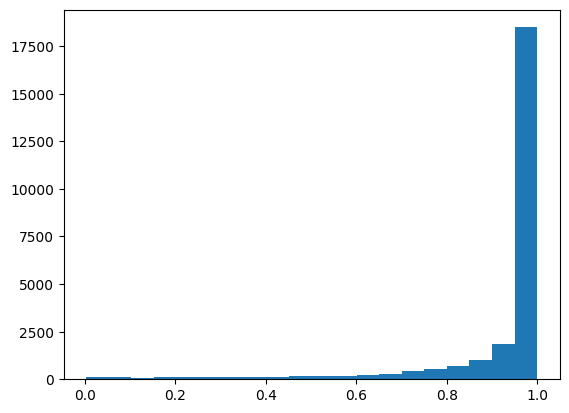

In [35]:
fig, ax = plt.subplots()
ax.hist(link_pred.detach().numpy(), bins=20)
fig.show()